In [1]:
import numpy as np
import matplotlib.pyplot as plt


def generate_TN_TS_uni(dt, L, phi, sigma, lag, tau, show_plot=False):
    """
    Generates time series data for TN and TS.
    
    Parameters:
      dt       : float
                 Time step for generating the time vector.
      L        : int
                 Number of time points.
      phi      : float
                 Autoregressive parameter for TN (and red noise).
      sigma    : float
                 Standard deviation of the white noise.
      lag      : int
                 Lag used in updating TS.
      tau      : float
                 Characteristic timescale for TS evolution.
      show_plot: bool, optional (default: False)
                 Whether to show the plot.
                 
    Returns:
      t            : ndarray
                     Time vector.
      TN           : ndarray
                     AR(1) process time series.
      TS           : ndarray
                     TS time series (without red noise).
      TS_with_red  : ndarray
                     TS time series combined with red noise.
      snr_empirical: float
                     Empirical signal-to-noise ratio of TN.
    """
    # Create the time vector.
    t = np.linspace(0, L * dt, L, endpoint=False)
    
    # ---- Generate TN as an AR(1) process ----
    TN = np.zeros(L)
    TN[0] = np.random.normal(0, sigma)
    for i in range(1, L):
        TN[i] = phi * TN[i-1] + np.random.normal(0, sigma)
    
    # Calculate empirical signal variance from TN.
    signal_var = np.var(TN)
    noise_var = sigma**2
    snr_empirical = signal_var / noise_var
    print("Empirical SNR of TN:", snr_empirical)
    
    # ---- Generate TS as before ----
    TS_initial = 0   # Initial condition for TS
    TS = np.zeros(L)
    TS[0] = TS_initial
    for i in range(1, L - lag):
        TS[i+lag] = TS[i] + (1/tau) * (-TN[i] - TS[i])
    
    # ---- Generate red noise (using the same AR(1) process for simplicity) ----
    red_noise = np.zeros(L)
    red_noise[0] = np.random.normal(0, sigma)
    for i in range(1, L):
        red_noise[i] = phi * red_noise[i-1] + np.random.normal(0, sigma)
    
    # Combine the original TS with red noise
    TS_with_red = TS + red_noise
    
    # Plot the results if requested.
    if show_plot:
        plt.figure(figsize=(15, 6))
        plt.plot(t, TN, label='TN (AR process)')
        plt.plot(t, TS, label='TS (without red noise)')
        plt.plot(t, TS_with_red, label='TS with red noise', linestyle='--')
        plt.xlabel('Time')
        plt.ylabel('Temperature Anomaly')
        plt.title('TN, TS, and TS with Red Noise Time Series')
        plt.legend()
        plt.show()
    
    return TN, TS_with_red



Empirical SNR of TN: 2.521252355312338


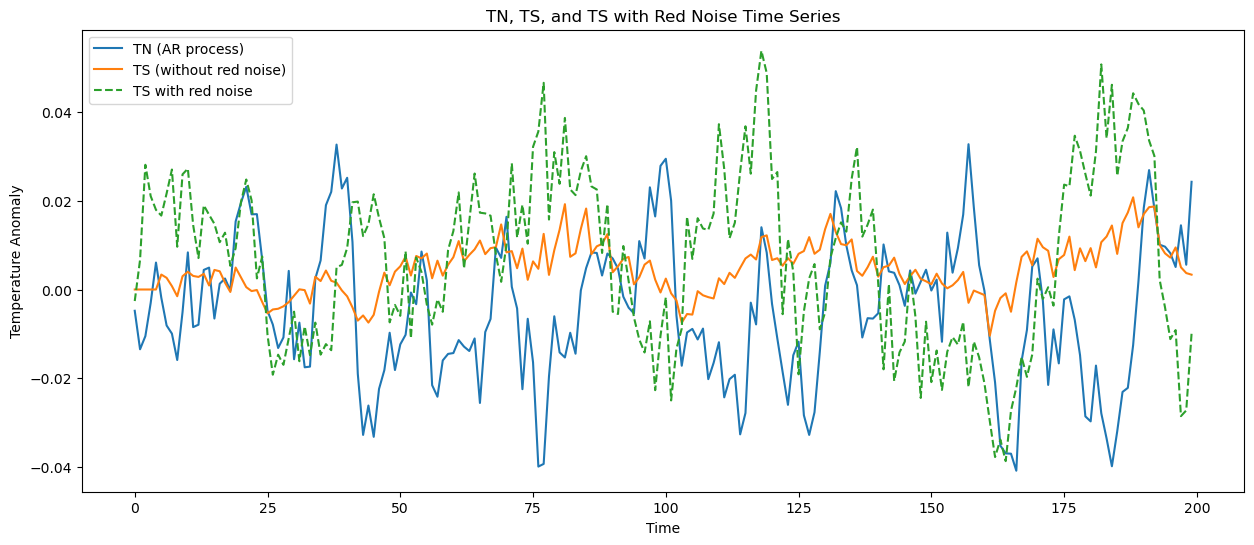

In [2]:

TN, TS_with_red = generate_TN_TS_uni(dt=1, L=200, phi=0.8, sigma=0.01, lag=4, tau=4, show_plot=True)



##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = gp_dc
tau_min = 1
tau_max = 7
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable X 1 has 2 link(s):
    [pc_alpha = 0.2]
        (X 1 -1): max_pval = 0.00000, |min_val| =  0.617
        (X 1 -3): max_pval = 0.10800, |min_val| =  0.149

    Variable X 2 has 3 link(s):
    [pc_alpha = 0.1]
        (X 2 -1): max_pval = 0.00000, |min_val| =  0.454
        (X 1 -4): max_pval = 0.04800, |min_val| =  0.171
        (X 2 -2): max_pval = 0.05200, |min_val| =  0.166

##
## Step 2: MCI algorithm
##

Parameters:

independence test = gp_dc
tau_min = 1
tau_max = 7
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.01:

    Variable X 1 has 1 link(s):
        (X 1 -1): pval = 0.00000 | val =  0.579

    Variable X 2 has 3 link(s):
        (X 2 -1): pval = 0.00000 | val =  0.476
        (X 1 -4

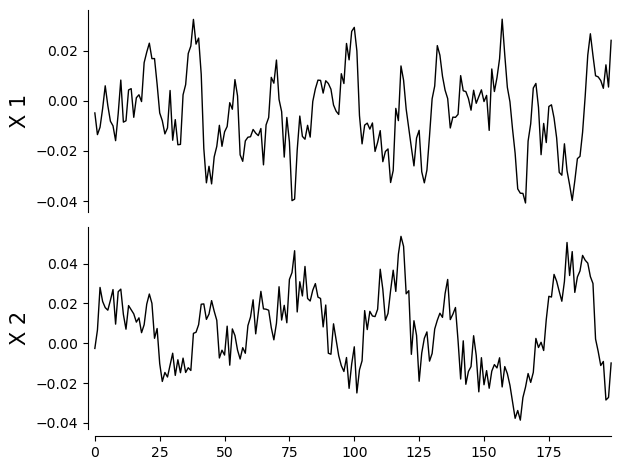

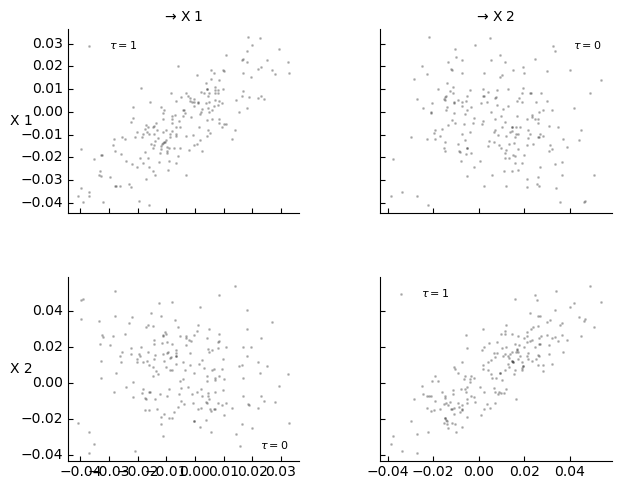


##
## Estimating lagged dependencies 
##

Parameters:

independence test = gp_dc
tau_min = 0
tau_max = 20


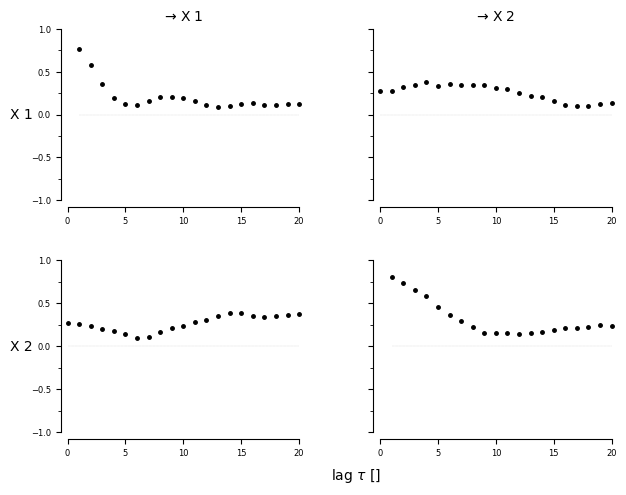

(<Figure size 700x700 with 1 Axes>, <Axes: >)

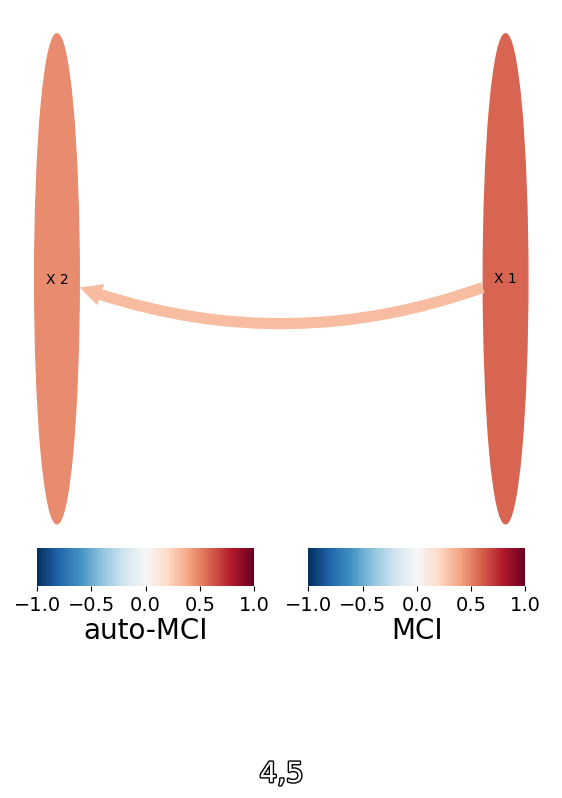

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr, gpdc, cmiknn
import pandas as pd

var_names = [r'X 1', r'X 2']
data_array = np.array([TN, TS_with_red]).T

# create adataframe called 'df4stationary_check' with the data_array and the variable names
df4stationary_check= pd.DataFrame(data_array, columns=var_names)

dataframe_TEMP = pp.DataFrame(data_array, datatime=np.arange(data_array.shape[0]), var_names=var_names)
tp.plot_timeseries(dataframe_TEMP,label_fontsize=15,tick_label_size=10)


gpdc_test = gpdc.GPDC(significance='analytic', gp_params=None)
pcmci_gpdc = PCMCI(
    dataframe=dataframe_TEMP, 
    cond_ind_test=gpdc_test,
    verbosity=0)

pcmci_gpdc.verbosity = 1
tau_max=7

results = pcmci_gpdc.run_pcmci(tau_max=tau_max, tau_min=1, pc_alpha=None, alpha_level = 0.01)

matrix_lags = None #np.argmax(np.abs(correlations), axis=2)
tp.plot_scatterplots(dataframe=dataframe_TEMP, add_scatterplot_args={'matrix_lags':matrix_lags}); plt.show()
correlations = pcmci_gpdc.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                    'x_base':5, 'y_base':.5}); plt.show()

# create a figure
fig, ax = plt.subplots(1, 1, figsize=(7, 7), dpi=100)
tp.plot_graph(
    fig_ax=(fig, ax),
    graph = results['graph'],
    val_matrix=results['val_matrix'],
    var_names=var_names,
    link_colorbar_label='MCI',
    node_colorbar_label='auto-MCI',
    link_label_fontsize=20,
    label_fontsize=20,
    tick_label_size=14,
    node_label_size=10,
    edge_ticks=0.5,
    node_ticks=0.5,
    node_size=0.2
    )

In [22]:
import numpy as np
from toolbox import GC_functions as GC  # Assuming GC_functions is your custom module
from toolbox import syth_ana_functions as saf
import importlib
importlib.reload(saf)
import numpy as np
import matplotlib.pyplot as plt
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr, gpdc, cmiknn

ParCorr = parcorr.ParCorr(significance='analytic')

gpdc_test = gpdc.GPDC(significance='analytic', gp_params=None)

Method = 'gpdc' # 'parcorr' or 'gpdc'


# Initialize parameters
noise_level = np.arange(0.001, 0.01, 0.001)  # From 0.1 to 1.0 in steps of 0.1
lags = range(1,11)  # From 0 to 10

iterations = 10
causal_AB_results = np.zeros((len(noise_level), len(lags)))
causal_BA_results = np.zeros((len(noise_level), len(lags)))

causal_AB_true_count_all = np.zeros((len(noise_level), len(lags)))
causal_BA_true_count_all = np.zeros((len(noise_level), len(lags)))

# Loop through combinations of causal strengths and lags
for i, sigma in enumerate(noise_level):
    for j, lag in enumerate(lags):
        causal_AB_true_count = 0
        causal_BA_true_count = 0
        
        for _ in range(iterations):
            # Generate dummy data and linked data
            # dummy_data = saf.gen_dummy_DO(length=1500, delta=10.0, t0=800.0, dt=56.32925780771254, dy=1.0, GS_slope=0.00016431508734689263, GIS_slope=-0.0009404944834246113, sigma=0.06633234778696487, tau=13.649751415738818)
            # dummy_warming_lagged = saf.gen_linked_data(dummy_data, causal_strength=strength, delta=10.0, lag=-lag, tau=13.649751415738818, sigma=0.06633234778696487)
            
            TN, TS = generate_TN_TS_uni(dt=1, L=200, phi=0.8, sigma=sigma, lag=lag, tau=4, show_plot=False)

            # dummy_warming_lagged = saf.gen_single_directional_data(length=1500, delta=10.0, lag=-lag, t0=800.0, dt=56.32925780771254, dy=1.0, GS_slope=0.00016431508734689263, GIS_slope=-0.0009404944834246113, tau=13.649751415738818, beta=5e-5, sigma=0.05)
            
            # df_checked = GC.make_stationary(dummy_warming_lagged,['A', 'B'], test_method='ADF', plot=False)
            # AB_array = df_checked[['A', 'B']].values
            # Combine TN and TS into a single array, they are two columns
            AB_array = np.array([TN, TS]).T
            #print the shape of the array
            print(AB_array.shape)

            var_names=['A', 'B']
            # Create a Tigramite DataFrame object
            dataframe_sta = pp.DataFrame(AB_array,
                                    datatime=np.arange(len(AB_array)),
                                    var_names=var_names)

            # results = []
            if Method == 'gpdc':
                pcmci_gpdc = PCMCI(
                    dataframe=dataframe_sta, 
                    cond_ind_test=gpdc_test,
                    verbosity=0)
                # pcmci_gpdc.verbosity = 1
                results = pcmci_gpdc.run_pcmci(tau_max=lag+1, tau_min=1, pc_alpha=None, alpha_level = 0.05)

            
            elif Method == 'parcorr':
                tau_max=lag+1
                pcmci = PCMCI(
                dataframe=dataframe_sta,
                cond_ind_test=ParCorr,
                verbosity=1)

                pcmci.verbosity = 0
                results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=None)

            p_matrix = results['p_matrix']
            alpha_level = 0.05

            result = saf.get_link_direction(p_matrix, alpha_level)

            causal_AB = result[0]
            causal_BA = result[1]

            
            # causal_AB = np.random.choice([True, False])
            # causal_BA = np.random.choice([True, False])
            
            if causal_AB:
                causal_AB_true_count += 1
            if causal_BA:
                causal_BA_true_count += 1
        
        # Calculate the percentages
        causal_AB_results[i, j] = causal_AB_true_count / iterations
        causal_BA_results[i, j] = causal_BA_true_count / iterations

        causal_AB_results[i, j]  = causal_AB_results[i, j]  >= 0.95
        causal_BA_results[i, j] = causal_BA_results[i, j] >= 0.95

        causal_AB_true_count_all[i, j] = causal_AB_true_count
        causal_BA_true_count_all[i, j] = causal_BA_true_count

causal_results = np.where((causal_AB_results == 1) & (causal_BA_results == 0), 1, 0)




Empirical SNR of TN: 2.0288456956672123
(200, 2)
Empirical SNR of TN: 2.43350787504964
(200, 2)
Empirical SNR of TN: 2.8628107474639752
(200, 2)
Empirical SNR of TN: 1.8525997311203768
(200, 2)
Empirical SNR of TN: 1.925684150523997
(200, 2)
Empirical SNR of TN: 2.293591216256004
(200, 2)
Empirical SNR of TN: 3.044226545749959
(200, 2)
Empirical SNR of TN: 2.879189397072205
(200, 2)
Empirical SNR of TN: 3.075227424259759
(200, 2)
Empirical SNR of TN: 3.346862584049299
(200, 2)
Empirical SNR of TN: 2.2228753777577563
(200, 2)
Empirical SNR of TN: 3.076494993328619
(200, 2)
Empirical SNR of TN: 3.108391360841467
(200, 2)
Empirical SNR of TN: 2.9408031094462186
(200, 2)
Empirical SNR of TN: 2.5804692967389267
(200, 2)
Empirical SNR of TN: 2.4585582900354757
(200, 2)
Empirical SNR of TN: 3.1209716845271585
(200, 2)
Empirical SNR of TN: 1.5246746941498883
(200, 2)
Empirical SNR of TN: 2.6177453180071995
(200, 2)
Empirical SNR of TN: 2.677969996547041
(200, 2)
Empirical SNR of TN: 3.55335047

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 2.669877653092973
(200, 2)
Empirical SNR of TN: 3.1958072261785655
(200, 2)
Empirical SNR of TN: 2.947795543824342
(200, 2)
Empirical SNR of TN: 2.5250449693005788
(200, 2)
Empirical SNR of TN: 2.0188483930039136
(200, 2)
Empirical SNR of TN: 1.874190661678027
(200, 2)
Empirical SNR of TN: 2.723398106321965
(200, 2)
Empirical SNR of TN: 2.161998373193241
(200, 2)
Empirical SNR of TN: 2.644022983796966
(200, 2)
Empirical SNR of TN: 2.3013886111970976
(200, 2)
Empirical SNR of TN: 1.8250167824373393
(200, 2)
Empirical SNR of TN: 2.196796890544829
(200, 2)
Empirical SNR of TN: 2.3608975482842376
(200, 2)
Empirical SNR of TN: 2.6013189060247353
(200, 2)
Empirical SNR of TN: 3.0789847447201018
(200, 2)
Empirical SNR of TN: 3.0088277657553535
(200, 2)
Empirical SNR of TN: 2.152882906979796
(200, 2)
Empirical SNR of TN: 2.2685966088892853
(200, 2)
Empirical SNR of TN: 1.9872612791771929
(200, 2)
Empirical SNR of TN: 2.472664826152323
(200, 2)
Empirical SNR of TN: 2.642288

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 4.009794604493079
(200, 2)
Empirical SNR of TN: 2.510146520850016
(200, 2)
Empirical SNR of TN: 2.3492180151659086
(200, 2)
Empirical SNR of TN: 2.894385595233418
(200, 2)
Empirical SNR of TN: 3.760930235518599
(200, 2)
Empirical SNR of TN: 2.5035247759152623
(200, 2)


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 3.0538934368198953
(200, 2)
Empirical SNR of TN: 4.0342360632521785
(200, 2)
Empirical SNR of TN: 2.594692212612076
(200, 2)


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 2.3515938049309377
(200, 2)
Empirical SNR of TN: 3.247175492078746
(200, 2)
Empirical SNR of TN: 2.796972464329689
(200, 2)
Empirical SNR of TN: 2.7134220808590586
(200, 2)
Empirical SNR of TN: 2.8062544290135443
(200, 2)
Empirical SNR of TN: 2.2300604496223118
(200, 2)
Empirical SNR of TN: 3.7135555489703993
(200, 2)
Empirical SNR of TN: 2.494571250530776
(200, 2)
Empirical SNR of TN: 2.780195336169998
(200, 2)
Empirical SNR of TN: 2.3236964686310206
(200, 2)
Empirical SNR of TN: 2.9831626499013324
(200, 2)
Empirical SNR of TN: 3.723724074724688
(200, 2)
Empirical SNR of TN: 2.394870081716789
(200, 2)
Empirical SNR of TN: 2.975151972140507
(200, 2)
Empirical SNR of TN: 3.0512348971661845
(200, 2)
Empirical SNR of TN: 2.015402879865185
(200, 2)
Empirical SNR of TN: 2.7547346626070612
(200, 2)
Empirical SNR of TN: 2.7618051036752296
(200, 2)
Empirical SNR of TN: 2.2499501070450307
(200, 2)
Empirical SNR of TN: 1.6937179033979861
(200, 2)
Empirical SNR of TN: 2.07402

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 3.81133533112181
(200, 2)
Empirical SNR of TN: 2.3236684977078403
(200, 2)
Empirical SNR of TN: 3.0849768509553197
(200, 2)
Empirical SNR of TN: 2.282572687560967
(200, 2)
Empirical SNR of TN: 2.007192150944581
(200, 2)
Empirical SNR of TN: 2.7326162286059863
(200, 2)
Empirical SNR of TN: 2.1432927387854335
(200, 2)
Empirical SNR of TN: 3.389596940494659
(200, 2)
Empirical SNR of TN: 2.5019815438004067
(200, 2)
Empirical SNR of TN: 2.3065152805621665
(200, 2)
Empirical SNR of TN: 2.1567330240933793
(200, 2)
Empirical SNR of TN: 3.3603095448471687
(200, 2)
Empirical SNR of TN: 1.655392659278451
(200, 2)
Empirical SNR of TN: 3.5752569978211945
(200, 2)
Empirical SNR of TN: 2.844329897563078
(200, 2)
Empirical SNR of TN: 3.01594413646528
(200, 2)
Empirical SNR of TN: 2.3766959474333804
(200, 2)
Empirical SNR of TN: 2.4553464752011958
(200, 2)
Empirical SNR of TN: 2.779560089714908
(200, 2)
Empirical SNR of TN: 2.386355131132756
(200, 2)
Empirical SNR of TN: 2.28014643

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 2.2501253227202165
(200, 2)
Empirical SNR of TN: 3.0973881761895323
(200, 2)
Empirical SNR of TN: 3.2508820620481993
(200, 2)
Empirical SNR of TN: 1.8509012388248893
(200, 2)
Empirical SNR of TN: 3.6385943040585063
(200, 2)
Empirical SNR of TN: 2.8094884970384526
(200, 2)
Empirical SNR of TN: 2.791142243287995
(200, 2)


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 3.0405936507888875
(200, 2)
Empirical SNR of TN: 2.153169858102935
(200, 2)
Empirical SNR of TN: 1.887909415851494
(200, 2)
Empirical SNR of TN: 2.0643297306370045
(200, 2)
Empirical SNR of TN: 2.3300083590377287
(200, 2)
Empirical SNR of TN: 3.0822738286293285
(200, 2)


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 2.234146878226576
(200, 2)
Empirical SNR of TN: 2.5920633688596264
(200, 2)
Empirical SNR of TN: 2.5914545343309294
(200, 2)
Empirical SNR of TN: 1.672902517134189
(200, 2)
Empirical SNR of TN: 3.3173082719816698
(200, 2)
Empirical SNR of TN: 3.4020598527241983
(200, 2)
Empirical SNR of TN: 2.301546455942432
(200, 2)
Empirical SNR of TN: 3.8553651725383062
(200, 2)
Empirical SNR of TN: 2.054704059972643
(200, 2)
Empirical SNR of TN: 2.755090027608499
(200, 2)
Empirical SNR of TN: 3.0557212183393174
(200, 2)
Empirical SNR of TN: 3.5727561430279438
(200, 2)
Empirical SNR of TN: 2.1715277419679233
(200, 2)
Empirical SNR of TN: 2.6572130489062062
(200, 2)
Empirical SNR of TN: 2.839093081869826
(200, 2)
Empirical SNR of TN: 2.4213336474922342
(200, 2)
Empirical SNR of TN: 2.8140936340256015
(200, 2)
Empirical SNR of TN: 2.8577164360811644
(200, 2)
Empirical SNR of TN: 2.6480171506833146
(200, 2)
Empirical SNR of TN: 2.7688350741825105
(200, 2)
Empirical SNR of TN: 3.562

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 3.0540844603260577
(200, 2)
Empirical SNR of TN: 3.5636565169667227
(200, 2)
Empirical SNR of TN: 2.4686771149401934
(200, 2)
Empirical SNR of TN: 2.5248677240392805
(200, 2)
Empirical SNR of TN: 2.499771488865704
(200, 2)
Empirical SNR of TN: 2.836664050500854
(200, 2)
Empirical SNR of TN: 2.0233305558500114
(200, 2)
Empirical SNR of TN: 3.634537535142466
(200, 2)
Empirical SNR of TN: 2.4873218386189437
(200, 2)
Empirical SNR of TN: 2.4180552107307816
(200, 2)
Empirical SNR of TN: 2.599345861396728
(200, 2)
Empirical SNR of TN: 2.2074547476706043
(200, 2)
Empirical SNR of TN: 3.178207413826084
(200, 2)
Empirical SNR of TN: 3.383619825600348
(200, 2)
Empirical SNR of TN: 2.54767757882036
(200, 2)
Empirical SNR of TN: 2.226888691057967
(200, 2)
Empirical SNR of TN: 2.6137677132365957
(200, 2)
Empirical SNR of TN: 3.2551805289405884
(200, 2)
Empirical SNR of TN: 1.9117857872042534
(200, 2)
Empirical SNR of TN: 2.419924369243044
(200, 2)
Empirical SNR of TN: 1.9279956

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 2.8457924426798424
(200, 2)
Empirical SNR of TN: 2.57116182136534
(200, 2)
Empirical SNR of TN: 3.183698978187793
(200, 2)
Empirical SNR of TN: 1.9668636247134872
(200, 2)
Empirical SNR of TN: 3.3488272356005435
(200, 2)


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 2.390291711982993
(200, 2)
Empirical SNR of TN: 2.7456762152519616
(200, 2)
Empirical SNR of TN: 2.7585473523722484
(200, 2)
Empirical SNR of TN: 2.584306489223478
(200, 2)
Empirical SNR of TN: 1.4857213189124447
(200, 2)
Empirical SNR of TN: 2.6176352942248697
(200, 2)
Empirical SNR of TN: 2.841634097990112
(200, 2)
Empirical SNR of TN: 3.111077547571344
(200, 2)
Empirical SNR of TN: 2.609406876830972
(200, 2)
Empirical SNR of TN: 2.7479119001027685
(200, 2)
Empirical SNR of TN: 1.6065848550513775
(200, 2)
Empirical SNR of TN: 1.840110184732718
(200, 2)
Empirical SNR of TN: 2.7129873915222475
(200, 2)
Empirical SNR of TN: 1.890965546256815
(200, 2)
Empirical SNR of TN: 2.3575436953059583
(200, 2)
Empirical SNR of TN: 2.6585160689117044
(200, 2)
Empirical SNR of TN: 2.0555379502604554
(200, 2)
Empirical SNR of TN: 2.9748020182404793
(200, 2)
Empirical SNR of TN: 2.02018186400516
(200, 2)
Empirical SNR of TN: 2.9724360551934623
(200, 2)
Empirical SNR of TN: 2.673677

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 2.1099720180264856
(200, 2)


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 2.179204256931985
(200, 2)
Empirical SNR of TN: 2.7387423070992436
(200, 2)
Empirical SNR of TN: 2.0625578895002
(200, 2)
Empirical SNR of TN: 2.055023384191657
(200, 2)
Empirical SNR of TN: 2.779819031558829
(200, 2)
Empirical SNR of TN: 2.599381165064084
(200, 2)


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 2.32527332393192
(200, 2)
Empirical SNR of TN: 2.289703550269346
(200, 2)
Empirical SNR of TN: 4.2331856934103085
(200, 2)
Empirical SNR of TN: 2.843555498865034
(200, 2)
Empirical SNR of TN: 3.732814426095863
(200, 2)
Empirical SNR of TN: 2.3946637672788165
(200, 2)
Empirical SNR of TN: 2.393260312960023
(200, 2)


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 2.9971741376893584
(200, 2)
Empirical SNR of TN: 2.1320728311704866
(200, 2)
Empirical SNR of TN: 2.308427843591816
(200, 2)
Empirical SNR of TN: 1.9603386092930137
(200, 2)
Empirical SNR of TN: 2.3355539488366066
(200, 2)
Empirical SNR of TN: 2.9679064597540585
(200, 2)
Empirical SNR of TN: 2.019642480652686
(200, 2)
Empirical SNR of TN: 2.7914683229562853
(200, 2)
Empirical SNR of TN: 2.7184013896076378
(200, 2)
Empirical SNR of TN: 2.6782229891882134
(200, 2)
Empirical SNR of TN: 2.3511073091254038
(200, 2)
Empirical SNR of TN: 2.9242213125022984
(200, 2)
Empirical SNR of TN: 4.319588443714486
(200, 2)
Empirical SNR of TN: 2.3314952637539537
(200, 2)
Empirical SNR of TN: 2.5646286372668103
(200, 2)
Empirical SNR of TN: 1.8711905235093553
(200, 2)
Empirical SNR of TN: 4.083445791673522
(200, 2)
Empirical SNR of TN: 3.0070191044528323
(200, 2)
Empirical SNR of TN: 2.0429346855610144
(200, 2)
Empirical SNR of TN: 2.7931915093841297
(200, 2)
Empirical SNR of TN: 2.5

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 3.293267558681615
(200, 2)
Empirical SNR of TN: 3.8028780791891967
(200, 2)
Empirical SNR of TN: 1.8261720605587226
(200, 2)
Empirical SNR of TN: 2.0037674022480685
(200, 2)
Empirical SNR of TN: 3.2203140063028513
(200, 2)
Empirical SNR of TN: 3.0294852215827808
(200, 2)
Empirical SNR of TN: 1.8567714791432832
(200, 2)
Empirical SNR of TN: 2.161733840123202
(200, 2)
Empirical SNR of TN: 2.475929461911769
(200, 2)
Empirical SNR of TN: 2.261355441966674
(200, 2)
Empirical SNR of TN: 1.6916955831627876
(200, 2)
Empirical SNR of TN: 3.620053446600878
(200, 2)
Empirical SNR of TN: 1.677930768124753
(200, 2)
Empirical SNR of TN: 2.2303650550026832
(200, 2)
Empirical SNR of TN: 2.1172376804562796
(200, 2)
Empirical SNR of TN: 3.2447884077017233
(200, 2)
Empirical SNR of TN: 2.8713404533090996
(200, 2)
Empirical SNR of TN: 2.3356856110671025
(200, 2)
Empirical SNR of TN: 2.040336417523272
(200, 2)
Empirical SNR of TN: 2.731444201639705
(200, 2)
Empirical SNR of TN: 2.70232

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 2.6435607118058813
(200, 2)
Empirical SNR of TN: 2.2347499145911023
(200, 2)
Empirical SNR of TN: 1.9958888922195253
(200, 2)
Empirical SNR of TN: 2.8198907421529578
(200, 2)
Empirical SNR of TN: 2.850031438153532
(200, 2)
Empirical SNR of TN: 4.314897547554214
(200, 2)
Empirical SNR of TN: 3.083452278165774
(200, 2)
Empirical SNR of TN: 2.1253000902269985
(200, 2)


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 2.7908540409872087
(200, 2)
Empirical SNR of TN: 2.903332264342684
(200, 2)
Empirical SNR of TN: 2.251436610531039
(200, 2)
Empirical SNR of TN: 2.8689433348010445
(200, 2)
Empirical SNR of TN: 2.919651123007408
(200, 2)
Empirical SNR of TN: 1.9528868521102831
(200, 2)
Empirical SNR of TN: 2.0019945299479835
(200, 2)
Empirical SNR of TN: 3.425892919005749
(200, 2)
Empirical SNR of TN: 2.9566635364385827
(200, 2)
Empirical SNR of TN: 3.1394065864537395
(200, 2)
Empirical SNR of TN: 3.3772688054869198
(200, 2)
Empirical SNR of TN: 1.7520043968748447
(200, 2)
Empirical SNR of TN: 2.2180696440253067
(200, 2)
Empirical SNR of TN: 1.7726262070958474
(200, 2)
Empirical SNR of TN: 2.3145543891254996
(200, 2)
Empirical SNR of TN: 3.2892603363136703
(200, 2)
Empirical SNR of TN: 2.9274974868756316
(200, 2)
Empirical SNR of TN: 2.029957260382858
(200, 2)
Empirical SNR of TN: 2.1931286939748653
(200, 2)


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 3.726672384301018
(200, 2)
Empirical SNR of TN: 1.812892515781246
(200, 2)
Empirical SNR of TN: 1.4884496660854925
(200, 2)
Empirical SNR of TN: 2.063202899891377
(200, 2)
Empirical SNR of TN: 2.6773514733093333
(200, 2)
Empirical SNR of TN: 2.250752636429172
(200, 2)
Empirical SNR of TN: 2.6692198532930425
(200, 2)
Empirical SNR of TN: 2.5230227443055764
(200, 2)
Empirical SNR of TN: 1.9136310314003497
(200, 2)
Empirical SNR of TN: 2.6457959822484716
(200, 2)
Empirical SNR of TN: 2.2397024530151195
(200, 2)
Empirical SNR of TN: 2.525715800570245
(200, 2)
Empirical SNR of TN: 2.449086280834637
(200, 2)
Empirical SNR of TN: 2.105836782700195
(200, 2)
Empirical SNR of TN: 2.01631330735719
(200, 2)
Empirical SNR of TN: 3.240524845616314
(200, 2)
Empirical SNR of TN: 3.3495435944369216
(200, 2)
Empirical SNR of TN: 2.4832923875447963
(200, 2)
Empirical SNR of TN: 2.562573542358052
(200, 2)
Empirical SNR of TN: 2.2757366661019605
(200, 2)
Empirical SNR of TN: 1.90324161

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 2.6791755787093003
(200, 2)
Empirical SNR of TN: 2.8512151983946143
(200, 2)
Empirical SNR of TN: 3.632875438126407
(200, 2)
Empirical SNR of TN: 2.9592340213218487
(200, 2)
Empirical SNR of TN: 3.2707376415509195
(200, 2)
Empirical SNR of TN: 2.1348248257650373
(200, 2)


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 2.2611350384168585
(200, 2)
Empirical SNR of TN: 2.1902674054734153
(200, 2)
Empirical SNR of TN: 2.576516142589492
(200, 2)
Empirical SNR of TN: 3.396709600964058
(200, 2)
Empirical SNR of TN: 3.082153317211275
(200, 2)
Empirical SNR of TN: 2.686637065296501
(200, 2)
Empirical SNR of TN: 3.500908781961033
(200, 2)
Empirical SNR of TN: 2.8209232849650783
(200, 2)
Empirical SNR of TN: 2.2848540458165774
(200, 2)
Empirical SNR of TN: 1.9551851143328838
(200, 2)
Empirical SNR of TN: 2.861171467566861
(200, 2)
Empirical SNR of TN: 2.6083033788726655
(200, 2)
Empirical SNR of TN: 2.090516729800167
(200, 2)
Empirical SNR of TN: 3.1488970642202547
(200, 2)
Empirical SNR of TN: 2.065429549892728
(200, 2)
Empirical SNR of TN: 2.4956366814728432
(200, 2)
Empirical SNR of TN: 2.3817458309828528
(200, 2)
Empirical SNR of TN: 2.8546728155694425
(200, 2)
Empirical SNR of TN: 2.846391161250386
(200, 2)
Empirical SNR of TN: 2.633638484312281
(200, 2)
Empirical SNR of TN: 2.4681068

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 2.5159873593641175
(200, 2)
Empirical SNR of TN: 2.537735868943363
(200, 2)
Empirical SNR of TN: 2.941628516915294
(200, 2)
Empirical SNR of TN: 2.3931908821848387
(200, 2)
Empirical SNR of TN: 2.57149116494135
(200, 2)
Empirical SNR of TN: 3.6715910355845933
(200, 2)
Empirical SNR of TN: 2.544337012097254
(200, 2)
Empirical SNR of TN: 2.1816614988484306
(200, 2)
Empirical SNR of TN: 2.538913158163786
(200, 2)
Empirical SNR of TN: 2.1403063941388667
(200, 2)
Empirical SNR of TN: 2.4725064443922
(200, 2)
Empirical SNR of TN: 2.817467411785439
(200, 2)
Empirical SNR of TN: 3.360228221233054
(200, 2)
Empirical SNR of TN: 2.960267899682133
(200, 2)
Empirical SNR of TN: 2.415355707691577
(200, 2)
Empirical SNR of TN: 3.0942754304912796
(200, 2)
Empirical SNR of TN: 3.096702142646276
(200, 2)
Empirical SNR of TN: 3.585790341100217
(200, 2)
Empirical SNR of TN: 2.644132421774839
(200, 2)


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 1.9179278649100524
(200, 2)
Empirical SNR of TN: 2.665135478065772
(200, 2)
Empirical SNR of TN: 2.724244972349202
(200, 2)
Empirical SNR of TN: 2.746520846332235
(200, 2)
Empirical SNR of TN: 2.1788308960741705
(200, 2)
Empirical SNR of TN: 2.766425859119585
(200, 2)
Empirical SNR of TN: 2.9458055650069963
(200, 2)
Empirical SNR of TN: 2.7152073124991167
(200, 2)
Empirical SNR of TN: 3.051784805546148
(200, 2)
Empirical SNR of TN: 2.7995175320200927
(200, 2)
Empirical SNR of TN: 2.297009564622932
(200, 2)
Empirical SNR of TN: 1.8775221242719635
(200, 2)
Empirical SNR of TN: 2.5162770701013417
(200, 2)


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 3.1745722024186995
(200, 2)
Empirical SNR of TN: 3.1768430024849117
(200, 2)
Empirical SNR of TN: 2.9824760726583492
(200, 2)
Empirical SNR of TN: 2.318469051866738
(200, 2)
Empirical SNR of TN: 3.4196907287187046
(200, 2)
Empirical SNR of TN: 2.9306312251047064
(200, 2)
Empirical SNR of TN: 2.1911710564516844
(200, 2)
Empirical SNR of TN: 2.158066299693484
(200, 2)
Empirical SNR of TN: 2.834471836694936
(200, 2)


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 3.2710578477167824
(200, 2)
Empirical SNR of TN: 2.7827328301060716
(200, 2)
Empirical SNR of TN: 2.7468609337341943
(200, 2)
Empirical SNR of TN: 2.4299683418318265
(200, 2)
Empirical SNR of TN: 1.811951859200909
(200, 2)
Empirical SNR of TN: 2.8859798487695696
(200, 2)
Empirical SNR of TN: 3.1843369833781097
(200, 2)
Empirical SNR of TN: 2.465717488507316
(200, 2)
Empirical SNR of TN: 2.044641661466512
(200, 2)
Empirical SNR of TN: 2.449311152249509
(200, 2)
Empirical SNR of TN: 1.8116163206239855
(200, 2)
Empirical SNR of TN: 2.372462475923724
(200, 2)
Empirical SNR of TN: 3.1419781816135353
(200, 2)
Empirical SNR of TN: 3.2070551475232545
(200, 2)
Empirical SNR of TN: 2.896075521972441
(200, 2)
Empirical SNR of TN: 3.559944685549068
(200, 2)
Empirical SNR of TN: 2.371416276402372
(200, 2)
Empirical SNR of TN: 2.886718995356427
(200, 2)
Empirical SNR of TN: 1.9932982015120178
(200, 2)
Empirical SNR of TN: 3.329333013331235
(200, 2)
Empirical SNR of TN: 1.6725317

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 1.8326955922546282
(200, 2)
Empirical SNR of TN: 2.933897000823548
(200, 2)
Empirical SNR of TN: 3.218248902456239
(200, 2)
Empirical SNR of TN: 2.7607303057087917
(200, 2)
Empirical SNR of TN: 3.341577811794857
(200, 2)
Empirical SNR of TN: 2.756453415812627
(200, 2)
Empirical SNR of TN: 2.4698482313291064
(200, 2)
Empirical SNR of TN: 3.1007420292728587
(200, 2)
Empirical SNR of TN: 2.1344468035401176
(200, 2)
Empirical SNR of TN: 3.5565109481622157
(200, 2)
Empirical SNR of TN: 1.7655873147976369
(200, 2)
Empirical SNR of TN: 2.3046508722251033
(200, 2)
Empirical SNR of TN: 1.9899266654794159
(200, 2)
Empirical SNR of TN: 4.121714606579642
(200, 2)
Empirical SNR of TN: 2.8046221958003312
(200, 2)
Empirical SNR of TN: 2.5788573971338544
(200, 2)
Empirical SNR of TN: 2.315761485456349
(200, 2)


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 3.264993593863912
(200, 2)
Empirical SNR of TN: 2.218064346771775
(200, 2)
Empirical SNR of TN: 2.699119467445498
(200, 2)
Empirical SNR of TN: 3.3951752791469842
(200, 2)
Empirical SNR of TN: 2.10337806067972
(200, 2)
Empirical SNR of TN: 1.9277351761626502
(200, 2)
Empirical SNR of TN: 2.6907254403920353
(200, 2)
Empirical SNR of TN: 3.4383434531907144
(200, 2)
Empirical SNR of TN: 2.763028838762633
(200, 2)
Empirical SNR of TN: 2.6975214321315764
(200, 2)
Empirical SNR of TN: 2.5757026188065444
(200, 2)
Empirical SNR of TN: 2.6720951004777693
(200, 2)


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 2.444553342870032
(200, 2)
Empirical SNR of TN: 2.6061749373485035
(200, 2)
Empirical SNR of TN: 2.3413586674265843
(200, 2)
Empirical SNR of TN: 2.78548357104152
(200, 2)
Empirical SNR of TN: 2.7300263574618393
(200, 2)


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 1.7594554207329904
(200, 2)
Empirical SNR of TN: 2.8829288619809983
(200, 2)
Empirical SNR of TN: 3.7011984828021163
(200, 2)
Empirical SNR of TN: 3.01708732176758
(200, 2)
Empirical SNR of TN: 2.5419594852581815
(200, 2)
Empirical SNR of TN: 2.4006167658514195
(200, 2)
Empirical SNR of TN: 3.0630873597524992
(200, 2)
Empirical SNR of TN: 2.7443334759957927
(200, 2)
Empirical SNR of TN: 1.9735203217117079
(200, 2)
Empirical SNR of TN: 2.3673693349722633
(200, 2)


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 3.4251125203751873
(200, 2)
Empirical SNR of TN: 2.651343087031544
(200, 2)
Empirical SNR of TN: 2.612958402081719
(200, 2)
Empirical SNR of TN: 2.8092239383151614
(200, 2)
Empirical SNR of TN: 3.36624155708422
(200, 2)
Empirical SNR of TN: 2.256645353255276
(200, 2)
Empirical SNR of TN: 3.6475217455500544
(200, 2)
Empirical SNR of TN: 2.6980023886309823
(200, 2)
Empirical SNR of TN: 1.905174650955129
(200, 2)
Empirical SNR of TN: 3.02715850166848
(200, 2)
Empirical SNR of TN: 1.8546234142611602
(200, 2)
Empirical SNR of TN: 2.014200446707978
(200, 2)


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 3.5970136340827397
(200, 2)


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Empirical SNR of TN: 2.7409435498302273
(200, 2)


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


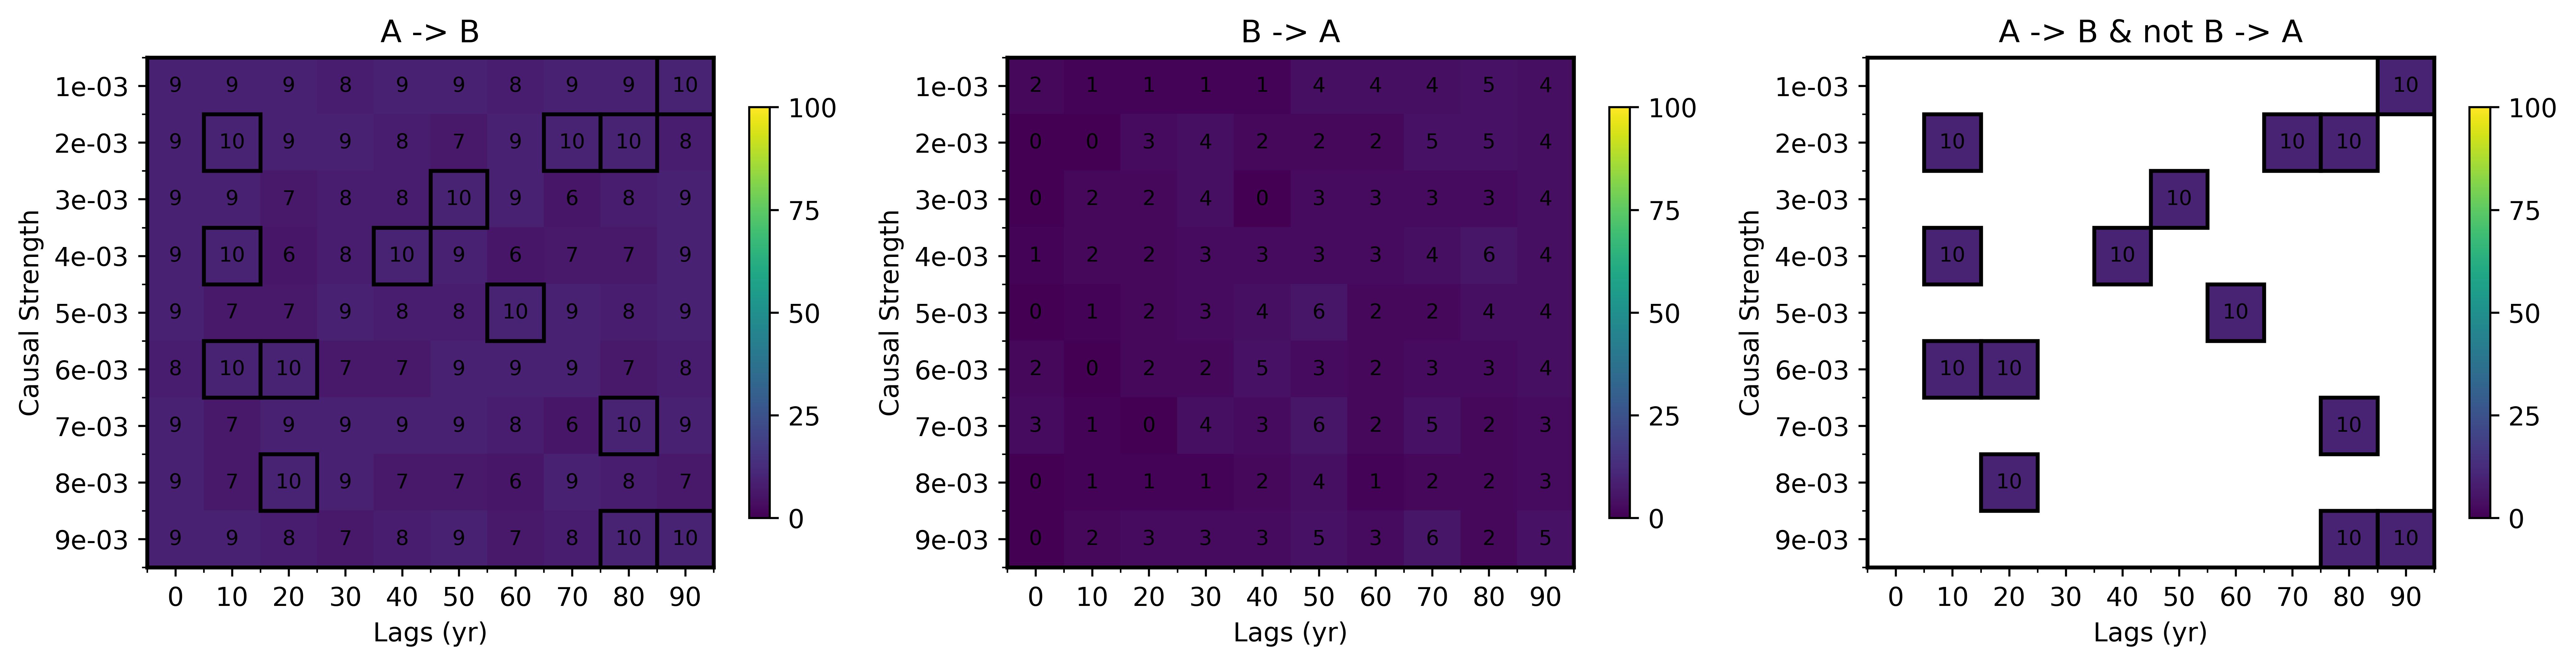

In [23]:
from toolbox import syth_ana_functions as saf
import importlib
importlib.reload(saf)
import matplotlib.pyplot as plt

noise_level = np.arange(0.001, 0.01, 0.001)  # From 0.1 to 1.0 in steps of 0.1
lags = range(1,11)  # From 0 to 10

X=lags
Y=noise_level

fig, axs = plt.subplots(1, 3, figsize=(14,4), dpi=600)  # 1 row, 3 columns of plots

# Plot each of the causal matrices with text annotations
saf.causal_colormap_ax(causal_AB_results, causal_AB_true_count_all, axs[0], X=X, Y=Y, title='A -> B', ylabel='Causal Strength',show_counts=True)
saf.causal_colormap_ax(causal_BA_results, causal_BA_true_count_all, axs[1], X=X, Y=Y, title='B -> A', ylabel='Causal Strength',show_counts=True)

# create AB_BA_count, and if causal_results_red_nozscore is 1, set the value in AB_BA count to the value from the causal_AB_true_count_all
AB_BA_count = np.zeros((len(noise_level), len(lags)))
for i in range(len(noise_level)):
    for j in range(len(lags)):
        if causal_results[i,j] == 1:
            AB_BA_count[i,j] = causal_AB_true_count_all[i,j]
        else:
            AB_BA_count[i,j] = np.nan


# Assuming causal_results_red_nozscore is derived in your existing code
saf.causal_colormap_ax(causal_results=causal_results, counts=AB_BA_count, ax=axs[2], X=X, Y=Y, title='A -> B & not B -> A', ylabel='Causal Strength',show_counts=True)
plt.tight_layout()
plt.show()

In [4]:
from toolbox import post_processing_functions as ppf
import importlib
importlib.reload(ppf)


N = results['p_matrix'].shape[0]
var_names = var_names


results_text=ppf.print_significant_links(N, var_names, p_matrix=results['p_matrix'],
                                 val_matrix=results['val_matrix'],
                                 alpha_level=0.05)

causal_links = ppf.parse_results_to_dict(results_text, var_names)
causal_links

# causal_links = ppf.sort_causal_links_by_val(causal_links)
# causal_links

causal_links = ppf.clean_causal_links(causal_links)
causal_links  

causal_links4the_class = ppf.filter_single_class_causal_links(causal_links, 'X 1')
causal_links4the_class

    Variable X 1 has 2 link(s):
        (X 1 -1): pval = 0.00000 | val =  0.579
        (X 2 -7): pval = 0.04800 | val =  0.172
    Variable X 2 has 6 link(s):
        (X 2 -1): pval = 0.00000 | val =  0.476
        (X 1 -4): pval = 0.00000 | val =  0.307
        (X 1 -5): pval = 0.00600 | val =  0.214
        (X 1 -7): pval = 0.03800 | val =  0.175
        (X 2 -4): pval = 0.04800 | val =  0.172
        (X 2 -6): pval = 0.04800 | val =  0.170
''
'## Significant links at alpha = 0.05:'
'    Variable X 1 has 2 link(s):'
target var: X 1
'        (X 1 -1): pval = 0.00000 | val =  0.579'
Cause match found: <re.Match object; span=(8, 16), match='(X 1 -1)'>
Val match found: <re.Match object; span=(33, 47), match='| val =  0.579'>
['X', '1', '-1']
Cause name: X 1
Cause index: 0
'        (X 2 -7): pval = 0.04800 | val =  0.172'
Cause match found: <re.Match object; span=(8, 16), match='(X 2 -7)'>
Val match found: <re.Match object; span=(33, 47), match='| val =  0.172'>
['X', '2', '-7']
Cause na

{'X 1': []}